In [3]:
%matplotlib notebook
import matplotlib.pyplot as plt
from PIL import Image, ImageOps
import torch
import torchvision.transforms as transforms
import numpy as np
import yaml
import sys
import time
from scipy import interpolate
import os
import cv2
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
sys.path.append("../")

import pdb
from utils import flowlib
import models
import utils
import importlib
importlib.reload(utils)

exp = '../experiments/semiauto_annot/resnet50_vip+mpii_liteflow'

load_iter = 42000
config = "{}/config.yaml".format(exp)

In [4]:
class ArgObj(object):
    def __init__(self):
        pass

class Demo(object):
    def __init__(self, configfn, load_iter):
        args = ArgObj()
        with open(configfn) as f:
            config = yaml.load(f)
        for k, v in config.items():
            setattr(args, k, v)
        setattr(args, 'load_iter', load_iter)
        setattr(args, 'exp_path', os.path.dirname(configfn))
        
        self.model = models.__dict__[args.model['arch']](args.model, dist_model=False)
        self.model.load_state("{}/checkpoints".format(args.exp_path), args.load_iter, False)        
        self.model.switch_to('eval')
        
        self.data_mean = args.data['data_mean']
        self.data_div = args.data['data_div']
        
        self.img_transform = transforms.Compose([
            transforms.Normalize(self.data_mean, self.data_div)])
        
        self.args = args
        self.fuser = utils.Fuser(args.model['module']['nbins'], args.model['module']['fmax'])
        torch.cuda.synchronize()
        
    def def_input(self, image, repeat=1):
        self.rgb = image
        tensor = self.img_transform(torch.from_numpy(np.array(image).astype(np.float32).transpose((2,0,1))))
        self.image = tensor.unsqueeze(0).repeat(repeat,1,1,1).cuda()
    
    def run_seg(self, active_pts, still_pts, velocity=10., crf=False): # pts: list of (x,y)
        start = time.time()
        
        sparse = np.zeros((4, 2, self.image.size(2), self.image.size(3)), dtype=np.float32)
        mask = np.zeros((4, 2, self.image.size(2), self.image.size(3)), dtype=np.float32)
        for pt in active_pts:
            sparse[0,:,int(pt[1]),int(pt[0])] = np.array([velocity,0])
            sparse[1,:,int(pt[1]),int(pt[0])] = np.array([-velocity,0])
            sparse[2,:,int(pt[1]),int(pt[0])] = np.array([0, velocity])
            sparse[3,:,int(pt[1]),int(pt[0])] = np.array([0, -velocity])
            mask[:,:,int(pt[1]),int(pt[0])] = np.array([1, 1])
        for pt in still_pts:
            sparse[:,:,int(pt[1]),int(pt[0])] = np.array([0, 0])
            mask[:,:,int(pt[1]),int(pt[0])] = np.array([1, 1])
            
        sparse = torch.from_numpy(sparse).cuda()
        mask = torch.from_numpy(mask).cuda()
        self.model.set_input(self.image, torch.cat([sparse, mask], dim=1), None)
        
        prep_time = time.time() - start
        start = time.time()
        
        tensor_dict = self.model.eval(ret_loss=False)
        flow = tensor_dict['flow_tensors'][0].cpu().numpy()
        
        fw_time = time.time() - start
            
        return flow, [prep_time, fw_time]
        
    def run(self, arrows, crf=False):
        sparse = np.zeros((1, 2, self.image.size(2), self.image.size(3)), dtype=np.float32)
        mask = np.zeros((1, 2, self.image.size(2), self.image.size(3)), dtype=np.float32)
        for arr in arrows:
            sparse[0, :, int(arr[1]), int(arr[0])] = np.array(arr[2:4])
            mask[0, :, int(arr[1]), int(arr[0])] = np.array([1, 1])
        image_var = torch.autograd.Variable(self.image.cuda(), volatile=True)
        sparse_var = torch.autograd.Variable(torch.from_numpy(sparse).cuda(), volatile=True)
        mask_var = torch.autograd.Variable(torch.from_numpy(mask).cuda(), volatile=True)

        output, _ = self.model(image_var, torch.cat([sparse_var, mask_var], dim=1))
        output = torch.nn.functional.upsample(output, size=(image_var.size(2), image_var.size(3)), mode="bilinear")
        
        if crf:
            flow = utils.fusion_flow_tensor(output, self.args.model['module']['fmax'], crf=True, 
                                            image=np.array(self.rgb).transpose((2,0,1))[np.newaxis,...])
        else:
            flow = utils.fusion_flow_tensor(output, self.args.model['module']['fmax'], crf=False)
        
        return flow
    
class DrawSeg(object):
    def __init__(self):
        self.demo = Demo(config, load_iter)
    
    def init_image(self, img, velocity=10., th=0.5, zoom_factor=-1, realtime=False, large=False, silent=False):
        
        self.velocity = velocity
        self.th = th
        self.realtime = realtime
        self.large = large
        self.silent = silent
        self.zoom_factor = zoom_factor
        if large:
            rows, cols = 1,1
            self.fig = plt.figure(figsize=(6, 6))
        else:
            rows, cols = 2,4
            self.fig = plt.figure(figsize=(12, 6))
        
        if 'short_size' in self.demo.args.data.keys():
            img, _ = utils.image_resize(img, short_size=self.demo.args.data['short_size'])
        img, _ = utils.image_crop(img, self.demo.args.data['crop_size'])
        self.oriimg = img
        self.img = img
        
        self.ax = self.fig.add_subplot(rows, cols, 1)
        if not large:
            self.axs = self.fig.add_subplot(rows, cols, 2)
            self.axf = [self.fig.add_subplot(rows, cols, j) for j in range(5,9)]
            self.axm = self.fig.add_subplot(rows, cols, 3)

        plt.tight_layout()
        
        self.refresh()
        
        self.connect()

    def refresh(self):
        self.ax.cla()
        if not self.silent:
            self.status = self.ax.text(0, 0, "", va="bottom", ha="left", color='r')
            self.status.set_text("start")
            self.mode_status = self.ax.text(self.oriimg.width, 0, "", va="bottom", ha="left", color='r')
            self.mode_status.set_text("mode: add")

        img = self.oriimg
        self.img = img
        self.ax.imshow(img)
        self.ax.axis('off')
        if not self.large:
            self.axs.imshow(img)
            self.axs.axis('off')
            for j in range(4):
                self.axf[j].imshow(np.ones((img.height, img.width, 3), dtype=np.uint8) * 255)
                self.axf[j].axis('off')
            self.axm.imshow(np.zeros((img.height, img.width, 3), dtype=np.uint8))
            self.axm.axis('off')
        
        self.demo.def_input(img, repeat=4)
        
        self.ax.figure.show()
        self.zoom_bbox = [0, 0, self.oriimg.width, self.oriimg.height]
        self.active_pts = []
        self.still_pts = []
        self.obj_active_pts = []
        self.obj_still_pts = []
        self.add_mode = 0
        self.laid_mask = False
        
    def get_zoom_ratio(self):
        pts = self.active_pts + self.still_pts
        allx = [p[0] for p in pts]
        ally = [p[1] for p in pts]
        minx, maxx = min(allx), max(allx)
        miny, maxy = min(ally), max(ally)
        sz = max(maxx - minx, maxy - miny) * self.zoom_factor
        sz = sz//2 * 2
        return float(self.oriimg.width) / sz

    def zoom_points(self, pt):
        x, y = pt
        woff, hoff = self.zoom_bbox[0:2]
        sz = self.zoom_bbox[2] - self.zoom_bbox[0]
        ratio = float(self.oriimg.width) / sz
        xnew = (x - woff) * ratio
        ynew = (y - hoff) * ratio
        return [xnew, ynew]
    
    def unzoom_points(self, pt):
        x, y = pt
        woff, hoff = self.zoom_bbox[0:2]
        sz = self.zoom_bbox[2] - self.zoom_bbox[0]
        ratio = float(self.oriimg.width) / sz
        xnew = x / ratio + woff
        ynew = y / ratio + hoff
        return [xnew, ynew]
        
    def zoom(self):
        pts = self.active_pts + self.still_pts
        allx = [p[0] for p in pts]
        ally = [p[1] for p in pts]
        minx, maxx = min(allx), max(allx)
        miny, maxy = min(ally), max(ally)
        center = ((minx + maxx) //2, (miny + maxy) // 2)
        sz = min(max(maxx - minx, maxy - miny) * self.zoom_factor, self.oriimg.width)
        if sz == self.oriimg.width:
            self.zoom_bbox = [0, 0, sz, sz]
        else:
            sz = sz//2 * 2
            self.zoom_bbox = (center[0] - sz//2, center[1] - sz//2, center[0] + sz//2, center[1] + sz//2)
        self.img = self.oriimg.crop(self.zoom_bbox).resize(self.demo.args.data['crop_size'], Image.BICUBIC)
        self.demo.def_input(self.img, repeat=4)
    
    def unzoom(self, mask): # flow: NCHW
        bbox = [int(b) for b in self.zoom_bbox]
        h, w = mask.shape
        unzoom_mask = np.zeros(mask.shape, dtype=mask.dtype)
        sz = bbox[2] - bbox[0]
        mask_r = cv2.resize(mask, (sz, sz), interpolation=cv2.INTER_LINEAR)
        unzoom_mask[max(0,bbox[1]):min(h,bbox[3]), max(0,bbox[0]):min(w,bbox[2])] = \
            mask_r[max(0,-bbox[1]):min(sz,sz-bbox[3]+h), max(0,-bbox[0]):min(sz,sz-bbox[2]+w)]
        return unzoom_mask
        
    def print_info(self, string):
        if not self.silent:
            self.status.set_text(string)
            self.ax.figure.canvas.draw()
        
    def connect(self):
        self.cidpress = self.ax.figure.canvas.mpl_connect('button_press_event', self.on_press)
        self.cidkeypress = self.ax.figure.canvas.mpl_connect('key_press_event', self.on_key)
        
    def run_crf(self, mask, rgb): # mask: HW, rgb: HW3
        h, w = mask.shape
        #mask = 0.7 * (mask > 0.5).astype(np.float32)
        score = np.concatenate([1-mask[np.newaxis,:,:], mask[np.newaxis,:,:]], axis=0)
        return np.array(utils.densecrf(score, rgb, iter=1)).reshape(2, h, w)[1,:,:]
    
    def run_seg(self):
        self.print_info("Running")
        start = time.time()
        if len(self.active_pts + self.still_pts) > 1 and self.zoom_factor != -1:
            self.zoom()
            zoom_active_pts = [self.zoom_points(p) for p in self.active_pts]
            zoom_still_pts = [self.zoom_points(p) for p in self.still_pts]
            self.flow, times = self.demo.run_seg(zoom_active_pts, zoom_still_pts, self.velocity, False) # crf False
        else:
            self.flow, times = self.demo.run_seg(self.active_pts, self.still_pts, self.velocity, False) # crf False
        self.print_info("prep: {:.3g} s, fw: {:.3g} s".format(*times))
        self.mask_zoom = np.mean(np.fabs(self.flow), axis=(0,1))
        self.mask_zoom /= self.mask_zoom.max()
        self.maskori = self.unzoom(self.mask_zoom)
        self.crf = False
        self.vlz_seg()
        
    def vlz_seg(self):
        if not self.large:
            for j in range(4):
                self.axf[j].imshow(flowlib.flow_to_image(self.flow[j,...].transpose((1,2,0))))
            self.axm.imshow((255 * self.maskori).astype(np.uint8))
            mask = (self.mask_zoom > self.th)
            mask4c = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)
            mask4c[:,:,2] = 255 * mask.astype(np.uint8)
            blend = np.clip(mask4c[:,:,:3] * 0.5 + np.array(self.img) * 0.5, 0, 255).astype(np.uint8)
            self.axs.imshow(blend)
        
        if self.laid_mask:
            self.axmask.remove()
        self.laid_mask = True
        mask = (self.maskori > self.th)
        mask4c = np.zeros((mask.shape[0], mask.shape[1], 4), dtype=np.uint8)
        mask4c[:,:,2] = 255 * mask.astype(np.uint8)
        mask4c[:,:,3] = int(255 * 0.5)
        self.axmask = self.ax.imshow(mask4c)
        
        self.ax.figure.canvas.draw()
            
    def on_key(self, event):
        if event.key == 'e':
            self.run_seg()
        elif event.key == 's':
            if self.add_mode == 0:
                self.add_mode = 1
                if not self.silent:
                    self.mode_status.set_text("mode: sub")
            else:
                self.add_mode = 0
                if not self.silent:
                    self.mode_status.set_text("mode: add")
            self.ax.figure.canvas.draw()
#         elif event.key == 'c':
#             if hasattr(self, 'maskori'):
#                 if self.crf:
#                     self.mask = self.maskori
#                     self.crf = False
#                 else:
#                     self.mask = self.run_crf(self.maskori, np.array(self.img))
#                     self.crf = True
#                 self.vlz_seg()
        elif event.key == 'f':
            self.refresh()
            
    def on_press(self, event):
        pts = [event.xdata, event.ydata]
        if pts[0] < 0 or pts[0] >= self.oriimg.width or pts[1] < 0 or pts[1] >= self.oriimg.height:
            return
        if event.button == 1:
            if self.add_mode == 1:
                self.obj_still_pts.append(self.ax.plot(pts[0], pts[1], '+', color='r', mew=2, ms=6))
                #pts = self.unzoom_point(pts)
                self.still_pts.append(pts) # original scale
                if not self.silent:
                    self.status.set_text("still point #{} added".format(len(self.still_pts)-1))
            else:
                self.obj_active_pts.append(self.ax.plot(pts[0], pts[1], '+', color=(0, 1, 0), mew=2, ms=6))
                #pts = self.unzoom_point(pts)
                self.active_pts.append(pts)
                if not self.silent:
                    self.status.set_text("active point #{} added".format(len(self.active_pts)-1))
            if self.realtime:
                self.run_seg()
        if event.button == 3:
            x, y = event.xdata, event.ydata
            x, y = self.unzoom_points([x, y])
            if len(self.active_pts) > 0 or len(self.still_pts) > 0:
                dist = [abs(x - pt[0]) + abs(y - pt[1]) for pt in self.active_pts + self.still_pts]
                delidx = np.argmin(dist)
                if delidx < len(self.active_pts):
                    self.obj_active_pts[delidx].pop().remove()
                    del self.obj_active_pts[delidx]
                    del self.active_pts[delidx]
                    if not self.silent:
                        self.status.set_text("active point #{} removed".format(delidx))
                else:
                    delidx -= len(self.active_pts)
                    self.obj_still_pts[delidx].pop().remove()
                    del self.obj_still_pts[delidx]
                    del self.still_pts[delidx]
                    if not self.silent:
                        self.status.set_text("still point #{} removed".format(delidx))
                if self.realtime:
                    self.run_seg()

    def disconnect(self):
        self.ax.figure.canvas.mpl_disconnect(self.cidpress)
        self.ax.figure.canvas.mpl_disconnect(self.cidkeypress)


objseg = DrawSeg()

=> loading checkpoint '../experiments/semiauto_annot/resnet50_vip+mpii_liteflow/checkpoints/ckpt_iter_42000.pth.tar'
caution: missing keys from checkpoint ../experiments/semiauto_annot/resnet50_vip+mpii_liteflow/checkpoints/ckpt_iter_42000.pth.tar: module.image_encoder.layer2.0.downsample.1.num_batches_tracked
caution: missing keys from checkpoint ../experiments/semiauto_annot/resnet50_vip+mpii_liteflow/checkpoints/ckpt_iter_42000.pth.tar: module.image_encoder.layer4.1.bn1.num_batches_tracked
caution: missing keys from checkpoint ../experiments/semiauto_annot/resnet50_vip+mpii_liteflow/checkpoints/ckpt_iter_42000.pth.tar: module.image_encoder.layer3.1.bn1.num_batches_tracked
caution: missing keys from checkpoint ../experiments/semiauto_annot/resnet50_vip+mpii_liteflow/checkpoints/ckpt_iter_42000.pth.tar: module.image_encoder.layer2.0.bn2.num_batches_tracked
caution: missing keys from checkpoint ../experiments/semiauto_annot/resnet50_vip+mpii_liteflow/checkpoints/ckpt_iter_42000.pth.tar

<IPython.core.display.Javascript object>


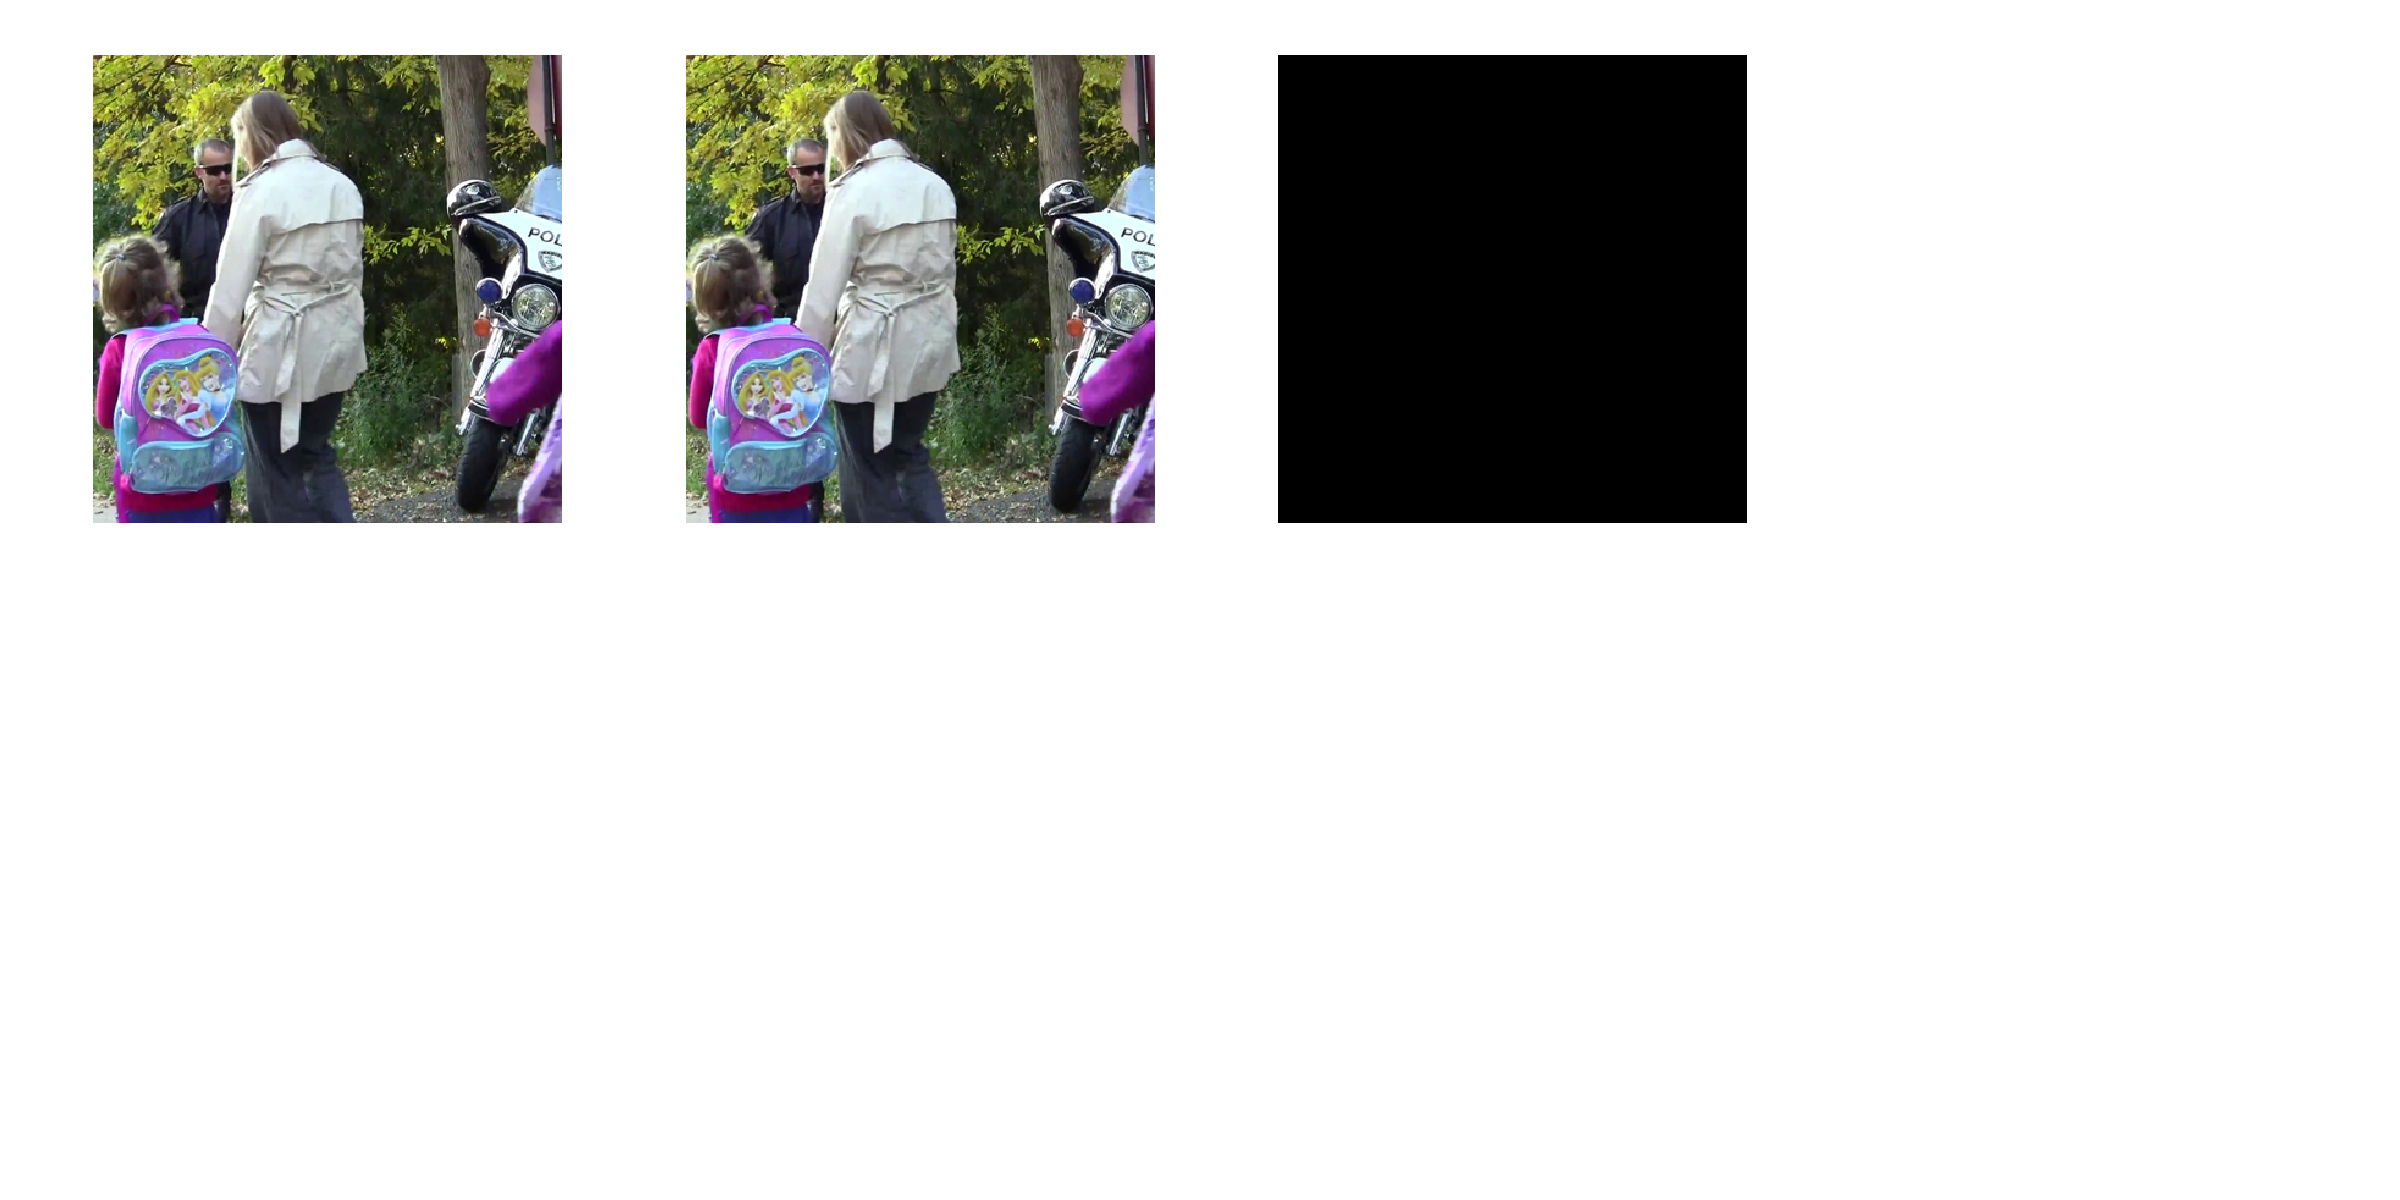

In [6]:
# tips:
# 1. left click to add positive points (green), avoid clicking too close to edges of objects..
# 2. right right to remove a nearset points.
# 3. press "s" to switch to negative mode where left click adds negative points (red). Press "s" again to switch back.
# 4. Points should not be too close to object boundaries.
# 5. For extremely tiny objects, click more than 2 points.
# 6. Press "f" to finish the current object.
# 7. Try to annotate any thing.

# arguments:
# velocity: dummy velocity
# th: threshold for mask
# zoom_factor: zoom in for tiny objects
# realtime: True: auto proceed, False: press 'e' to proceed
# large: True: large canvas, False: also show score heatmap, flow in 4 directions
# silent: show information or not

source = 'example'

if source == 'example':
    fn = 'example_images/0.jpg' # 0.jpg, 1.jpg, 2.jpg
else:
    test_image_idx = 0 # [0,1000)
    target = 'MPII'

    with open('/home/xhzhan/Share/transfer/{}/list.txt'.format(target), 'r') as f:
        lines = f.readlines()
    fns = ['/home/xhzhan/Share/transfer/{}/'.format(target) + l.strip() for l in lines]
    fn = fns[test_image_idx]

img = Image.open(fn).convert("RGB")
objseg.init_image(img, velocity=30., th=0.5, zoom_factor=4, realtime=True, large=False, silent=True)
